# Import Files

In [ ]:
import pandas as pd
import numpy as np
import random
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science Case Studies /new_churn_data.csv')


# Data Preperation

In [ ]:
dataset.isna().sum()

dataset = dataset.dropna()

In [ ]:
user_identifier = dataset['user']
dataset = dataset.drop(columns = ['user'])


In [ ]:
# One-Hot Encoding
dataset.head()


,churn,age,housing,deposits,withdrawal,purchases_partners,purchases,cc_taken,cc_recommended,cc_disliked,...,payment_type,waiting_4_loan,cancelled_loan,received_loan,rejected_loan,zodiac_sign,left_for_two_month_plus,left_for_one_month,reward_rate,is_referred
0,0,37.0,na,0,0,0,0,0,0,0,...,Bi-Weekly,0,0,0,0,Leo,1,0,0.00,0
1,0,28.0,R,0,0,1,0,0,96,0,...,Weekly,0,0,0,0,Leo,0,0,1.47,1
2,0,35.0,R,47,2,86,47,0,285,0,...,Semi-Monthly,0,0,0,0,Capricorn,1,0,2.17,0
3,0,26.0,R,26,3,38,25,0,74,0,...,Bi-Weekly,0,0,0,0,Capricorn,0,0,1.10,1
4,1,27.0,na,0,0,2,0,0,0,0,...,Bi-Weekly,0,0,0,0,Aries,1,0,0.03,0


In [ ]:
dataset.groupby('housing')['churn'].nunique().reset_index()


,housing,churn
0,O,2
1,R,2
2,na,2


In [ ]:
dataset = pd.get_dummies(dataset)


In [ ]:
dataset.columns


Index(['churn', 'age', 'deposits', 'withdrawal', 'purchases_partners',
       'purchases', 'cc_taken', 'cc_recommended', 'cc_disliked', 'cc_liked',
       'cc_application_begin', 'app_downloaded', 'web_user', 'ios_user',
       'android_user', 'registered_phones', 'waiting_4_loan', 'cancelled_loan',
       'received_loan', 'rejected_loan', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'is_referred', 'housing_O',
       'housing_R', 'housing_na', 'payment_type_Bi-Weekly',
       'payment_type_Monthly', 'payment_type_Semi-Monthly',
       'payment_type_Weekly', 'payment_type_na', 'zodiac_sign_Aquarius',
       'zodiac_sign_Aries', 'zodiac_sign_Cancer', 'zodiac_sign_Capricorn',
       'zodiac_sign_Gemini', 'zodiac_sign_Leo', 'zodiac_sign_Libra',
       'zodiac_sign_Pisces', 'zodiac_sign_Sagittarius', 'zodiac_sign_Scorpio',
       'zodiac_sign_Taurus', 'zodiac_sign_Virgo', 'zodiac_sign_na'],
      dtype='object')

In [ ]:
dataset = dataset.drop(columns = ['housing_na', 'zodiac_sign_na', 'payment_type_na'])


KeyError: ignored

# Train & Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns = 'churn'), dataset['churn'],
                                                    test_size = 0.2,
                                                    random_state = 0)


In [ ]:
# Balancing the Training Set
y_train.value_counts()


0    12656
1     8940
Name: churn, dtype: int64

In [ ]:
pos_index = y_train[y_train.values == 1].index
neg_index = y_train[y_train.values == 0].index


In [ ]:
if len(pos_index) > len(neg_index):
    higher = pos_index
    lower = neg_index
else:
    higher = neg_index
    lower = pos_index


In [ ]:
random.seed(0)
higher = np.random.choice(higher, size=len(lower))
lower = np.asarray(lower)
new_indexes = np.concatenate((lower, higher))


In [ ]:
X_train = X_train.loc[new_indexes,]
y_train = y_train[new_indexes]


# Feature scaling 

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))

In [ ]:
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2


# Model Building

In [ ]:
# Fitting Model to the Training Set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)


In [ ]:
classifier.fit(X_train, y_train)


LogisticRegression(random_state=0)

In [ ]:
# Predicting Test Set
y_pred = classifier.predict(X_test)


In [ ]:
# Evaluating Results
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
precision_score(y_test, y_pred) # tp / (tp + fp)
recall_score(y_test, y_pred) # tp / (tp + fn)
f1_score(y_test, y_pred)

0.43377674956622325

Test Data Accuracy: 0.6374


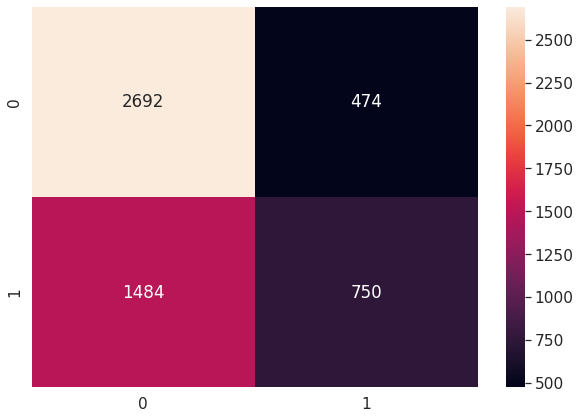

In [ ]:
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))


In [ ]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))


SVM Accuracy: 0.668 (+/- 0.017)


In [ ]:
# Analyzing Coefficients
pd.concat([pd.DataFrame(X_train.columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)



,features,coef
0,age,-0.140955
1,deposits,0.340467
2,withdrawal,0.076756
3,purchases_partners,-0.802957
4,purchases,-0.457818
5,cc_taken,0.076913
6,cc_recommended,0.029384
7,cc_disliked,0.036640
8,cc_liked,0.030948
9,cc_application_begin,0.007827


# Feature selection

In [ ]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [ ]:
# Select Best X Features
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=20)
rfe = rfe.fit(X_train, y_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
X_train.columns[rfe.support_]

[ True  True  True  True  True  True  True False False False  True  True
  True  True  True False False  True  True  True  True  True False False
 False  True False False  True False False False False False False False
 False  True False False False]
[ 1  1  1  1  1  1  1  5  7 19  1  1  1  1  1 18  3  1  1  1  1  1  8  4
 13  1  9 12  1 20 10  2  6 15 21 16 17  1 14 22 11]


Index(['age', 'deposits', 'withdrawal', 'purchases_partners', 'purchases',
       'cc_taken', 'cc_recommended', 'app_downloaded', 'web_user', 'ios_user',
       'android_user', 'registered_phones', 'received_loan', 'rejected_loan',
       'left_for_two_month_plus', 'left_for_one_month', 'reward_rate',
       'payment_type_Bi-Weekly', 'payment_type_Weekly',
       'zodiac_sign_Sagittarius'],
      dtype='object')

# New Corelation Matrix

<ipython-input-102-114d010b7e5f>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<Axes: >

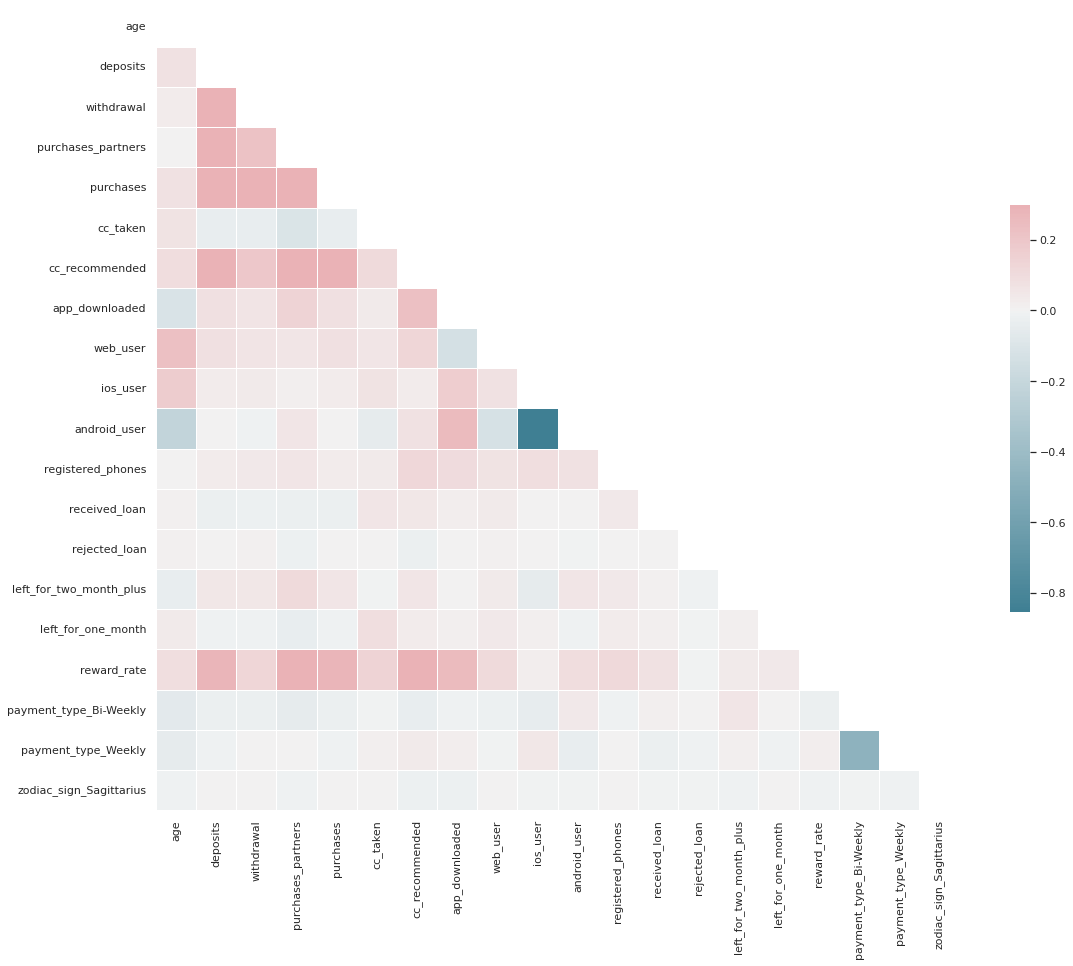

In [ ]:
# New Correlation Matrix
sn.set(style="white")

# Compute the correlation matrix
corr = X_train[X_train.columns[rfe.support_]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})  

# Fitting Model To the training set 

In [ ]:
# Fitting Model to the Training Set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train[X_train.columns[rfe.support_]], y_train)


LogisticRegression()

In [ ]:
# Predicting Test Set
y_pred = classifier.predict(X_test[X_train.columns[rfe.support_]])


In [ ]:
# Evaluating Results
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
precision_score(y_test, y_pred) # tp / (tp + fp)
recall_score(y_test, y_pred) # tp / (tp + fn)
f1_score(y_test, y_pred)


0.4252336448598131

Test Data Accuracy: 0.6356


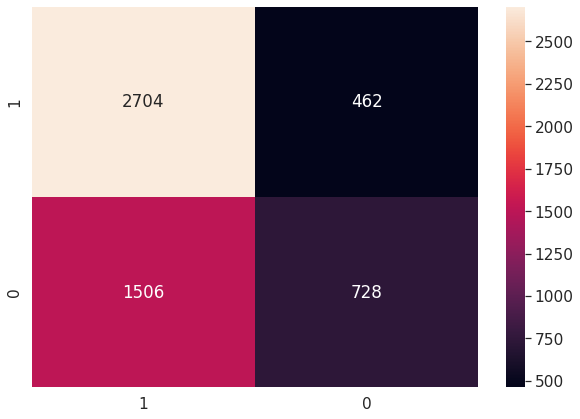

In [ ]:
df_cm = pd.DataFrame(cm, index = (1, 0), columns = (1, 0))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))


In [ ]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier,
                             X = X_train[X_train.columns[rfe.support_]],
                             y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

# Analyzing Coefficients
pd.concat([pd.DataFrame(X_train[X_train.columns[rfe.support_]].columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)


SVM Accuracy: 0.669 (+/- 0.015)


,features,coef
0,age,-0.149571
1,deposits,0.330198
2,withdrawal,0.080334
3,purchases_partners,-0.797741
4,purchases,-0.443605
5,cc_taken,0.089231
6,cc_recommended,0.053046
7,app_downloaded,-0.079270
8,web_user,0.139267
9,ios_user,0.168382


# End the model

In [ ]:
# Formatting Final Results
final_results = pd.concat([y_test, user_identifier], axis = 1).dropna()
final_results['predicted_churn'] = y_pred
final_results = final_results[['user', 'churn', 'predicted_churn']].reset_index(drop=True)
